# Running test set

In [53]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import time
import copy
import os
import sys
import argparse
from torch.utils.data import Dataset

import csv
from torch.autograd import Variable
import utils
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import yaml

In [54]:
'''
parser = argparse.ArgumentParser(description='PyTorch stochastic batch norm inference')
parser.add_argument('--model_path', default='', type=str, help='path to the model')
parser.add_argument('--test_dir', default='', type=str, help='Directory containing images' )
parser.add_argument('--cuda', action='store_true', help='use cuda')
parser.add_argument('--log_file', default='evalss_data')
parser.add_argument('--eval_rot', action='store_false', help='use 4 rotation for evaluation')
parser.add_argument('--eval_no_crop', action='store_false', help='skip center crop')
parser.add_argument('--n_tries', default=10, type=int)
parser.add_argument('--seed', default=42, type=int)
parser.add_argument('--output_dir', default='/home/asmita/sbn_infer/output', type=str, help='Output directory')
parser.add_argument('--running',action='store_false',help='using running mean (regular batch norm)')

args = parser.parse_args()
'''

"\nparser = argparse.ArgumentParser(description='PyTorch stochastic batch norm inference')\nparser.add_argument('--model_path', default='', type=str, help='path to the model')\nparser.add_argument('--test_dir', default='', type=str, help='Directory containing images' )\nparser.add_argument('--cuda', action='store_true', help='use cuda')\nparser.add_argument('--log_file', default='evalss_data')\nparser.add_argument('--eval_rot', action='store_false', help='use 4 rotation for evaluation')\nparser.add_argument('--eval_no_crop', action='store_false', help='skip center crop')\nparser.add_argument('--n_tries', default=10, type=int)\nparser.add_argument('--seed', default=42, type=int)\nparser.add_argument('--output_dir', default='/home/asmita/sbn_infer/output', type=str, help='Output directory')\nparser.add_argument('--running',action='store_false',help='using running mean (regular batch norm)')\n\nargs = parser.parse_args()\n"

In [55]:
model_path = 'networks/resnet-50.t7'
test_dir = 'zambia_hm/VGGnonref_Resref_hm/'
cuda = True 
log_file = 'evalss_data'
eval_rot = True
eval_no_crop = True
n_tries = 10
seed = 42
output_dir = '/home/asmita/Work/Asmita/output'
running = True

In [56]:

#test_dir = args.test_dir

#model_path = args.model_path 
print("loading model", model_path)

torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
np.random.seed(seed)

log_file = utils.uniquify(os.path.join(output_dir, log_file), sep='-')

eval_data = test_dir
net = utils.load_model(model_path, cuda)
dataloader = utils.get_dataloader(test_dir,
        [0.6000, 0.3946, 0.6041],
        [0.2124, 0.2335, 0.2360],
        eval_no_crop, eval_rot, batch_size=1)

if not running:
    net.eval()
    utils.set_strategy(net, 'sample')
    have_do =  utils.set_do_to_train(net)

    res = utils.predict_proba(dataloader, net, n_classes=5, return_logits=True, ensembles=n_tries, cuda=cuda)
    print('APPPP',res)
    '''
    eval_data['test'] = {
        'ensemble/proba': res[0],
        'ensemble/logits': res[2],
        'eval/labels': res[1],
        'ensemble/filenames': res[3]
    }    '''
else:
    net.eval()
    utils.set_strategy(net, 'running')
    have_do = utils.set_do_to_train(net)

    res = utils.predict_proba(dataloader, net, n_classes=5,
            return_logits=True, ensembles=n_tries if have_do else 3)
    print(type(eval_data))
    '''
    eval_data['test'].update({
        'eval/proba': res[0],
        'eval/logits': res[2],
        'eval/labels': res[1],
        'ensemble/filenames': res[3]
    }) '''


output_file_name = 'res_norotate'
torch.save(res, output_file_name)
print(res[2].shape)
print('Created output file \'', output_file_name , ' \' ')


loading model networks/resnet-50.t7


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/serialization.py:426: SourceChangeWarning: source code of class 'networks.resnet.ResNet' has changed. Saved a reverse patch to ResNet.patch. Run `patch -p0 < ResNet.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/serialization.py:426: SourceChangeWarning: source code of class 'networks.resnet.Bottleneck' has changed. Saved a reverse patch to Bottleneck.patch. Run `patch -p0 < Bottleneck.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
100%|██████████| 252/252 [00:15<00:00, 15.93it/s]

<class 'str'>
(3, 252, 5)
Created output file ' res_norotate  ' 


In [57]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from visual_explain import *

In [58]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [59]:
mega_table = pd.read_csv('all_predictions.csv')
ground_truth_sidrp = pd.read_csv('ground_truth_gilbert.csv').rename(columns={'selena_6_0':'label'})

/home/asmita/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Creating file list

In [60]:
import os

a = open("VGGnonref.txt", "w")
for path, subdirs, files in os.walk(r'/home/asmita/sbn_infer/zambia_hm/VGGnonref_Resref_hm/data'):
     for filename in files:
        f = os.path.join(path, filename)
        a.write(str(f) + os.linesep) 
print('File list created')

File list created


# Mean KL divergence from mean

In [61]:
# mean KL-divergence
from scipy.stats import entropy

def mean_kl(data, mean_dist):
    # estimate parameters over first axis
    means = np.zeros((data.shape[1]))
    for i in range(means.shape[0]):
#         kl_div_max = 0
        kl_div_acc = entropy([1-mean_dist[i],mean_dist[i]])*data.shape[0]
        for k in range(data.shape[0]):
            kl_div = entropy([1-data[k,i,1],data[k,i,1]],[1-mean_dist[i],mean_dist[i]])
            kl_div_acc += kl_div
#             if kl_div_max < kl_div:
#                 kl_div_max = kl_div
        means[i] = kl_div_acc/(data.shape[0])
#         means[i] = kl_div_max
    return means

In [62]:

def cross_entropy(data, mean_dist):
    # estimate parameters over first axis
    means = np.zeros((data.shape[1]))
    for i in range(means.shape[0]):
        ent_max = 0
        ent_p = entropy([1-mean_dist[i],mean_dist[i]])
        for k in range(data.shape[0]):
            kl_div = entropy([1-data[k,i,1],data[k,i,1]],[1-mean_dist[i],mean_dist[i]])
            ent = kl_div + ent_p
            if ent_max < ent:
                ent_max = ent
        means[i] = ent_max
#         means[i] = kl_div_max
    return means

# Plotting and comparsion functions¶

In [63]:
def performance_at_percentiles(df,uncertainty_measure,scoring_fn,percentiles,above=True):
    thresholds = np.percentile(df[uncertainty_measure],percentiles)
    def score_(threshold):
        if above:
            df_ =df[df[uncertainty_measure]>=threshold]
        else:
            df_ =df[df[uncertainty_measure]<threshold]
        return scoring_fn(df_)
    return [score_(threshold) for threshold in thresholds]
    
def plot_percentile_compare(scores_dict,percentiles,title,measure_name,above=True):
    
    plt.xlabel("k")
    plt.ylabel(measure_name)
    plt.title(title)
    #     plt.logx(steps[len(steps)-len(auc):],auc)
    for k,v in scores_dict.items():
        if above:
            plt.plot(100-percentiles,v,label=k)
        else:
            plt.plot(percentiles,v,label=k)
    plt.legend()
    
def get_scores(df,scoring_fn,percentiles,above=True):
    return {'Standard deviation':
                performance_at_percentiles(df,'std_0',scoring_fn,percentiles,above),
              'Entropy':
              performance_at_percentiles(df,'entropy_1',scoring_fn,percentiles,above),
           'Entropy of entropies':
             performance_at_percentiles(df,'entropy_score_1',scoring_fn,percentiles,above)
            #'Scores':
             #performance_at_percentiles(df,'score1',scoring_fn,percentiles,above)
#              ,
#             'hybrid':
#               performance_at_percentiles(df,'hybrid',scoring_fn,percentiles,above)
             }

    

def balanced_point(target, scores,sens_at_least=0.50):
    arr = np.asarray(roc_curve(target, scores))
    arr2 =arr[:,arr[1,:] > sens_at_least]
#     print(arr.shape, arr2.shape)
    min_point = np.argmin(np.square(1 - arr2[1,:])+np.square(arr2[0,:]))
#   min_point = np.argmin(arr2[0,:])
    return arr2[1,min_point],1-arr2[0,min_point],arr2[2,min_point]

def roc_percentile_above_compare(df):
    percentiles = np.arange(99,10,-2)
    scores = get_scores(df,lambda df_: roc_auc_score(df_['label']>=1,df_['mean_2']),percentiles)
    plot_percentile_compare(scores,percentiles,'AUC for top k uncertain predictions','AUC')

    
def roc_percentile_below_compare(df):
    percentiles = np.arange(80,100,1)
    scores = get_scores(df,lambda df_: roc_auc_score(df_['label']>=1,df_['mean_2']),percentiles,above=False)
    plot_percentile_compare(scores,percentiles,'AUC for bottom k uncertain predictions','AUC',above=False)


def balanced_accuracy(df_):
    _,_,threshold = balanced_point(df_['label']>=1,df_['mean_2'])
    return accuracy_score(df_['label']>=2,df_['mean_1']>=threshold)

def accuracy_below_compare(df):
    percentiles = np.arange(80,100,1)
    scores = get_scores(df,lambda df_:accuracy_score(df_['label']>=1,df_['mean_2']>=0),percentiles,above=False)
    plot_percentile_compare(scores,percentiles,'Accuracy for bottom k uncertain predictions','Accuracy',above=False)
    
def accuracy_above_compare(df):
    percentiles = np.arange(99,10,-2)
    scores = get_scores(df,lambda df_:accuracy_score(df_['label']>=1,df_['mean_2']>=0),percentiles)
    plot_percentile_compare(scores,percentiles,'Accuracy for top k uncertain predictions','Accuracy')
    
def label_below_compare(df):
    percentiles = np.arange(80,100,1)
    scores = get_scores(df,lambda df_:float((df_['label']>=1).sum())/len(df_),percentiles,above=False)
    plot_percentile_compare(scores,percentiles,'Ratio of positive label for bottom k uncertain predictions',
                            'Ratio of positive label',above=False)
    
def label_above_compare(df):
    percentiles = np.arange(99,10,-2)
    scores = get_scores(df,lambda df_:float((df_['label']>=1).sum())/len(df_),percentiles,above=True)
    plot_percentile_compare(scores,percentiles,'Ratio of positive label for top k uncertain predictions',
                            'Ratio of positive label')

    
def plot_all(df):
    '''
    roc_percentile_above_compare(df)
    plt.show()
    roc_percentile_below_compare(df)
    plt.show()
    '''
    accuracy_above_compare(df)
    plt.show()
    accuracy_below_compare(df)
    plt.show()
    label_above_compare(df)
    plt.show()
    label_below_compare(df)
    

# 0.3  Load predictions


In [64]:
#mega_table = pd.read_csv('all_predictions.csv')

In [65]:
res_names = pd.read_csv('VGGnonref.txt',names=['filename'])
res_names['filename'] = res_names['filename'].apply(lambda x:os.path.basename(x)[:-4])
res_names

,filename


In [66]:
res = torch.load(output_file_name)
#print(res)
logits = res[2]
print(logits.shape)

logits = logits.transpose((1,0,2))
print(logits.shape)
a = int(logits.shape[0]/4)
b = (logits.shape[1])*4

logits = logits.reshape(a,b,5)
logits = logits.transpose((1,0,2))

res_names = pd.read_csv('VGGnonref.txt',names=['filename'])
res_names['filename'] = res_names['filename'].apply(lambda x:os.path.basename(x)[:-4])

# res_names = pd.DataFrame({'filename':np.repeat(res_names['filename'].values,4)})
# res_names = pd.read_csv('selena_6_0_ml.csv',header=None,names=['filename','label_1'])

std_df  = pd.DataFrame(np.std(sigmoid(logits), axis=0),columns=['std_0','std_1','std_2','std_3','std_4'])
mean_df = pd.DataFrame(np.mean(sigmoid(logits), axis=0),columns=['mean_0','mean_1','mean_2','mean_3','mean_4'])
df = pd.concat([res_names, mean_df, std_df],axis=1)
print(len(df))
df['label'] = 0
df.label[0:12]=1
df.label[13:24]=2
df.label[25:36]=3
df.label[37:48]=4

#df = df.merge(ground_truth_sidrp,on='filename')
#roc_auc_score(df['label']==0,df['mean_1'])
df
roc_auc_score(df['label']>=2,df['mean_1'])

(3, 252, 5)
(252, 3, 5)
63


/home/asmita/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/asmita/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/asmita/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/asmita/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be s

0.36363636363636365

In [67]:
from scipy.stats import entropy

df['kl_div'] = mean_kl(sigmoid(logits),df['mean_1'])
df['entropy_1'] = df['mean_1'].apply(lambda x:entropy([1-x,x]))
df['entropy_score_1'] = df['entropy_1'].apply(lambda x:entropy([1-x,x]))
df.shape

(63, 15)

# Plotting uncertainty levels

(array([54.,  0.,  2.,  1.,  1.,  2.,  0.,  1.,  1.,  1.]),
 array([6.56785780e-12, 2.28297637e-03, 4.56595272e-03, 6.84892908e-03,
        9.13190544e-03, 1.14148818e-02, 1.36978582e-02, 1.59808345e-02,
        1.82638109e-02, 2.05467872e-02, 2.28297636e-02]),
 <a list of 10 Patch objects>)

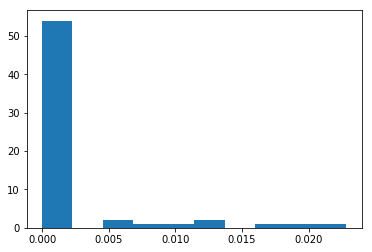

In [68]:
plt.hist(df['mean_2'])

(array([57.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.]),
 array([0.        , 0.00021833, 0.00043667, 0.000655  , 0.00087334,
        0.00109167, 0.00131001, 0.00152834, 0.00174668, 0.00196501,
        0.00218334]),
 <a list of 10 Patch objects>)

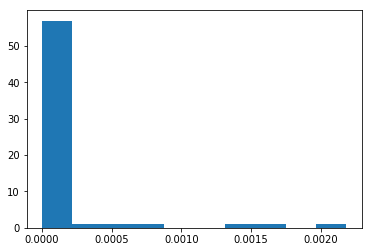

In [69]:
plt.hist(df['entropy_1'])

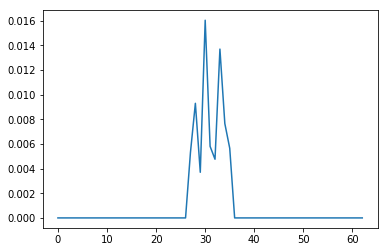

In [70]:
plt.plot(df['std_0'])

(array([57.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.]),
 array([0.        , 0.00021833, 0.00043667, 0.000655  , 0.00087334,
        0.00109167, 0.00131001, 0.00152834, 0.00174668, 0.00196501,
        0.00218334]),
 <a list of 10 Patch objects>)

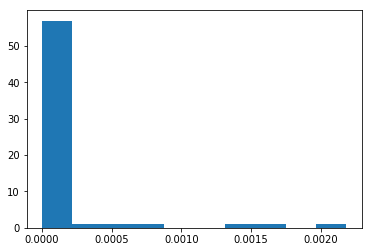

In [71]:
plt.hist(df['entropy_1'])

 # Plot performance measure above/under uncertainty measure¶

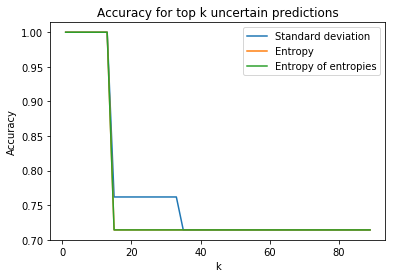

/home/asmita/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/asmita/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


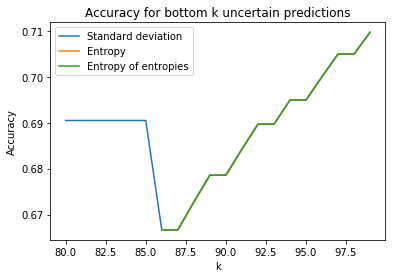

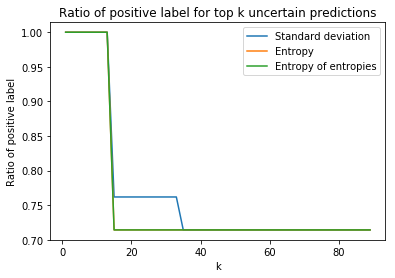

ZeroDivisionError: float division by zero

In [72]:
plot_all(df)

#  Datasets basic stats and performance

In [73]:
np.mean(df.std_0)
subset = df[df.std_0<0.00000000000000114]
subset

,filename,mean_0,mean_1,mean_2,mean_3,mean_4,std_0,std_1,std_2,std_3,std_4,label,kl_div,entropy_1,entropy_score_1
1,0540,1.0,1.0,1.701938e-07,6.739487e-09,1.856869e-08,0.0,0.0,1.116864e-07,8.388036e-09,1.986777e-08,1,0.0,0.0,0.0
2,1819 (3),1.0,1.0,1.028472e-07,2.418834e-09,2.025193e-08,0.0,0.0,9.663454e-08,2.361341e-09,2.920348e-08,1,0.0,0.0,0.0
4,1811,1.0,1.0,1.812053e-07,8.414854e-09,2.122864e-08,0.0,0.0,1.568892e-07,1.010331e-08,2.477414e-08,1,0.0,0.0,0.0
5,1805 (1),1.0,1.0,9.362853e-08,2.969604e-09,8.859208e-09,0.0,0.0,4.939938e-08,3.357948e-09,8.281643e-09,1,0.0,0.0,0.0
6,1773,1.0,1.0,1.484839e-07,4.374659e-09,1.308027e-08,0.0,0.0,1.220244e-07,4.969443e-09,1.283400e-08,1,0.0,0.0,0.0
7,0580 (4),1.0,1.0,1.768354e-07,6.359206e-09,3.521336e-08,0.0,0.0,1.565750e-07,7.396028e-09,4.769086e-08,1,0.0,0.0,0.0
8,0505 (1),1.0,1.0,2.906681e-07,1.245031e-08,4.060394e-08,0.0,0.0,3.451298e-07,1.683921e-08,5.052094e-08,1,0.0,0.0,0.0
10,NaN,1.0,1.0,2.294378e-07,6.841419e-09,2.612452e-08,0.0,0.0,1.215154e-07,7.580209e-09,2.806804e-08,1,0.0,0.0,0.0
11,NaN,1.0,1.0,1.308074e-07,5.679345e-09,2.395797e-08,0.0,0.0,1.082830e-07,6.385574e-09,3.287819e-08,1,0.0,0.0,0.0
14,NaN,1.0,1.0,1.179640e-07,3.738211e-09,1.841625e-08,0.0,0.0,6.575165e-08,4.005818e-09,2.096428e-08,2,0.0,0.0,0.0


In [74]:

df.groupby('label').count()

,filename,mean_0,mean_1,mean_2,mean_3,mean_4,std_0,std_1,std_2,std_3,std_4,kl_div,entropy_1,entropy_score_1
label,,,,,,,,,,,,,,
0,0,18,18,18,18,18,18,18,18,18,18,18,18,18
1,9,12,12,12,12,12,12,12,12,12,12,12,12,12
2,0,11,11,11,11,11,11,11,11,11,11,11,11,11
3,0,11,11,11,11,11,11,11,11,11,11,11,11,11
4,0,11,11,11,11,11,11,11,11,11,11,11,11,11


In [75]:
roc_auc_score(df['label']>=2,df['mean_1'])

0.36363636363636365

In [76]:
# Mean of rotations

def agg_std(x):
    return np.sqrt((x**2).sum())
agg_f = {'mean_0':'mean','mean_1':'mean','mean_2':'mean','mean_3':'mean',
        'std_0':agg_std,'std_1':agg_std,'std_2':agg_std,'std_3':agg_std,
        'kl_div':'mean','label':'max','entropy_1':'mean'}
rot_means = df.groupby('filename').agg(agg_f)
print(rot_means)

          mean_0  mean_1        mean_2        mean_3         std_0  std_1  \
filename                                                                    
0423         1.0     1.0  2.605009e-07  1.298694e-08  5.960464e-08    0.0   
0505 (1)     1.0     1.0  2.906681e-07  1.245031e-08  0.000000e+00    0.0   
0540         1.0     1.0  1.701938e-07  6.739487e-09  0.000000e+00    0.0   
0580 (4)     1.0     1.0  1.768354e-07  6.359206e-09  0.000000e+00    0.0   
0599 (2)     1.0     1.0  3.937657e-07  1.504643e-08  5.960464e-08    0.0   
1773         1.0     1.0  1.484839e-07  4.374659e-09  0.000000e+00    0.0   
1805 (1)     1.0     1.0  9.362853e-08  2.969604e-09  0.000000e+00    0.0   
1811         1.0     1.0  1.812053e-07  8.414854e-09  0.000000e+00    0.0   
1819 (3)     1.0     1.0  1.028472e-07  2.418834e-09  0.000000e+00    0.0   

                 std_2         std_3  kl_div  label  entropy_1  
filename                                                        
0423      2.228608e-07

# Visualization

In [77]:
from __future__ import print_function

import copy
import pandas as pd
import os

import click
import cv2
import numpy as np
import torch
from torch.autograd import Variable
from torchvision import models, transforms
from PIL import Image, ImageDraw
from grad_cam import (BackPropagation, Deconvolution, GradCAM, GuidedBackPropagation, IntegratedGradient)
from pathlib import Path
import utils
from networks.resnet import resnet
# if model has LSTM
# torch.backends.cudnn.enabled = False
import scipy.misc
from PIL import Image

import glob
import matplotlib
matplotlib.use('Agg')
import argparse
from pathlib import Path
import matplotlib.pyplot as plt

from collections import OrderedDict
# import visdom

/home/asmita/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/asmita/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/asmita/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/asmita/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/asmita/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/asmita/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start


In [78]:
def normalize(attrs, ptile=99):
    '''Normalize the provided attributions so that they fall between
    -1.0 and 1.0.
    '''
    h = np.percentile(attrs, ptile)
    l = np.percentile(attrs, 100-ptile)
    return np.clip(attrs/max(abs(h), abs(l)), -1.0, 1.0)  

def normalize_one_side(attrs, ptile=99):
    '''Normalize the provided attributions so that they fall between
    -1.0 and 1.0.
    '''
    h = np.percentile(attrs, ptile)
    return np.clip(attrs/h, 0.0, 1.0)  

R=np.array([255,0,0])
G=np.array([0,255,0])
B=np.array([0,0,255])

def preprocess_img(image_path):
    raw_image = cv2.imread(image_path)[..., ::-1]
    raw_image = cv2.resize(raw_image, (224, ) * 2)
    image = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.6000, 0.3946, 0.6041],
            std = [0.2124, 0.2335, 0.2360]
        )
    ])(raw_image).unsqueeze(0)
    return image

def gray_scale(img):
    '''Converts the provided RGB image to gray scale.
    '''
    img = np.average(img, axis=2)
    return np.transpose([img, img, img], axes=[1,2,0])


def pil_img(a):
    '''Returns a PIL image created from the provided RGB array.
    '''
    a = np.uint8(a)
    return Image.fromarray(a)

def visualize_attrs(img, attrs, pos_ch=G, neg_ch=R):
    '''Visaualizes the provided attributions by first aggregating them
     along the color channel and then overlaying the positive attributions
     along pos_ch, and negative attributions along neg_ch.

     The provided image and attributions must of shape (224, 224, 3).
    '''
#     attrs = gray_scale(attrs)
    # attrs = normalize(attrs,ptile=99.99)   
    pos_attrs = attrs * (attrs >= 0.0)
    neg_attrs = -1.0 * attrs * (attrs < 0.0)
    pos_attrs = normalize_one_side(pos_attrs,ptile=99.94)
    neg_attrs = normalize_one_side(neg_attrs,ptile=99.92)
    attrs_mask = pos_attrs*pos_ch   +  neg_attrs*neg_ch
    vis = 0.3*gray_scale(img) + 0.7*attrs_mask
    # vis = gray_scale(img) + 0.7*attrs_mask
#     vis = 0.3*np.asarray(img) + attrs_mask
#     vis = attrs_mask
    vis_ = pil_img(vis)
    return pil_img(vis),pil_img(attrs_mask)
    # return pil_img(sbs),pil_img(attrs_mask)

In [79]:
def load_resnet_stochbn(model_file):
    '''
    # discard last layer
    #model_ft = models.resnet50()
    model_ft = resnet(False, 50)
    #print(model_ft)
    model_ft.fc = torch.nn.Linear(model_ft.fc.in_features, 5)

    model_ft = model_ft.cuda()
    model_ft = torch.nn.DataParallel(
        model_ft, device_ids=range(torch.cuda.device_count()))
    #cudnn.benchmark = True
    checkpoint = torch.load(model_file)
    saved_state_dict = checkpoint['model'].state_dict()
    #new_state_dict = OrderedDict()
    #for k, v in saved_state_dict.items():
    #    name = k[7:] # remove `module.`
    #    new_state_dict[name] = v
    model_ft.load_state_dict(saved_state_dict)
    utils.set_strategy(model_ft, 'running')
    # utils.set_strategy(model_ft, 'sample')
    model_ft.bn1.strategy = 'sample'
    for m in model_ft.layer1.modules():
        m.bn1.strategy ='sample'
        m.bn2.strategy ='sample'
        m.bn3.strategy ='sample'
    '''    
    model_ft = models.resnet50()
    model_ft.fc = torch.nn.Linear(model_ft.fc.in_features, 5)

    model_ft = model_ft.cuda()
    model_ft = torch.nn.DataParallel(
        model_ft, device_ids=range(torch.cuda.device_count()))

    checkpoint = torch.load(model_file)
    model_ft.load_state_dict(checkpoint['model'].state_dict())
    return model_ft
    

def load_resnet(model_file):
    # discard last layer
    model_ft = models.resnet50()
    model_ft.fc = torch.nn.Linear(model_ft.fc.in_features, 5)

    model_ft = model_ft.cuda()
    model_ft = torch.nn.DataParallel(
        model_ft, device_ids=range(torch.cuda.device_count()))

    checkpoint = torch.load(model_file)
    model_ft.load_state_dict(checkpoint['model'].state_dict())
    return model_ft

def visdom_img(img, title):
    vis.image(np.asarray(img,dtype=np.uint8).transpose((2,0,1)), opts={'title':title})


In [80]:
'''
@click.command()
@click.option('-i', '--image_folder', type=str, required=True)
@click.option('-m', '--model_file', default='', type=str)
@click.option('--stoch_bn/--no_stoch_bn', default=False)
@click.option('-t', '--num_tries', default=1, type=int)
@click.option('-n','--name',type=str, default='')
'''

"\n@click.command()\n@click.option('-i', '--image_folder', type=str, required=True)\n@click.option('-m', '--model_file', default='', type=str)\n@click.option('--stoch_bn/--no_stoch_bn', default=False)\n@click.option('-t', '--num_tries', default=1, type=int)\n@click.option('-n','--name',type=str, default='')\n"

In [81]:
image_folder = 'zambia_hm/VGGnonref_Resref_hm'
model_file = 'models/resnet-50_best.t7'
stoch_bn = True
name = ''
num_tries = 1

In [82]:

device = torch.device('cuda')
current_device = torch.cuda.current_device()
print('Running on the GPU:', torch.cuda.get_device_name(current_device))

if stoch_bn:
    if model_file == '':
        model_file = '/models/resnet-50_sbn.t7'
    model = load_resnet_stochbn(model_file).module
else:
    if model_file == '':
        model_file = '/models/resnet-50_best.t7'
    model = load_resnet(model_file).module

model.to(device)
model.eval()
gcam = GradCAM(model=model)
gbp = GuidedBackPropagation(model=model)  
intgrad = IntegratedGradient(model=model, steps=10)
def integrated_gradient(image_path):
    image = preprocess_img(image_path)
   
    features = []
    probs_arr = []
    for i in range(num_tries):
        probs = intgrad.forward(image.to(device))
        probs = probs.cpu().detach().numpy()
        label =   np.around(probs)
        feature = intgrad.generate(probs * label)
        features.append(feature)
        probs_arr.append(probs)

    feature = np.stack(features, axis=0).mean(axis=0)+14
    feature_std = np.stack(features, axis=0).std(axis=0)
    probs = np.stack(probs_arr, axis=0).mean(axis=0)
 
    return features
    # return feature_std

def guided_gradcam(image_path, target_layer='layer4.2'):
    image = preprocess_img(image_path)
    regions = []
    features = []
    probs_arr = []
    for i in range(num_tries):
        probs = gcam.forward(image.to(device))
        target =   np.around(probs.cpu().detach().numpy())
        gcam.backward(idx=target)
        region = gcam.generate(target_layer=target_layer)
        probs = gbp.forward(image.to(device))
        target =   np.around(probs.cpu().detach().numpy())
        gbp.backward(idx=target)
        feature = gbp.generate()
        regions.append(region)
        features.append(feature)
        probs_arr.append(probs.cpu().detach().numpy())

    region = np.stack(regions, axis=0).mean(axis=0)
    feature = np.stack(features, axis=0).mean(axis=0)
    feature_std = np.stack(features, axis=0).std(axis=0)
    probs = np.stack(probs_arr, axis=0).mean(axis=0)

    h, w, _ = feature.shape
    region = cv2.resize(region, (w, h))[..., np.newaxis]
    # output = feature * region
    print('[{:.5f} {:.5f} {:.5f} {:.5f}]'.format(probs[0], probs[1] ,
    probs[2], probs[3]))
    return feature, region

for dirpath, dirnames, filenames in os.walk(image_folder):
    for file in filenames:
        if file.endswith('.png') or file.endswith('.jpg'):
            parts =dirpath.split('/')
            # cls = int(parts[-1]) 
            filepath = os.path.join(dirpath, file)
            print('Asmita')
            # feature, region = guided_gradcam(filepath, num_tries=1)
            print(filepath)
            feature_arr = integrated_gradient(filepath)
            # out, mask = visualize_attrs(Image.open(filepath).resize((224,224)), feature)
            # visdom_img(out, name+' '+file)
            output_dir = Path(dirpath.replace('data','n_stoch_bn'))
            output_dir.mkdir(parents=True, exist_ok=True)
            #print(np.asarray((feature_arr)[0].shape))
            # out.save(os.path.join(output_dir.as_posix(), file))
            np.save(os.path.join(output_dir.as_posix(), file), feature_arr)
            #scipy.misc.imsave(os.path.join(output_dir.as_posix(), file), feature_arr)
            print(os.path.join(output_dir.as_posix(), file))
            #output = np.delete(f, np.s_[:], axis = 0)
            #im = Image.fromarray(np.asarray(feature_arr)[0])
            #im.save(os.path.join(output_dir.as_posix(), file))
            #f = np.asarray(feature_arr)
            #scipy.misc.imsave(os.path.join(output_dir.as_posix(), file), f[0])
print('Visualization created')

Running on the GPU: Quadro M1000M


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/serialization.py:426: SourceChangeWarning: source code of class 'networks.resnet.ResNet' has changed. Saved a reverse patch to ResNet.patch. Run `patch -p0 < ResNet.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/serialization.py:426: SourceChangeWarning: source code of class 'networks.resnet.Bottleneck' has changed. Saved a reverse patch to Bottleneck.patch. Run `patch -p0 < Bottleneck.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
 

Asmita
zambia_hm/VGGnonref_Resref_hm/output/0423.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output/0423.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output/0540.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output/0540.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output/1819 (3).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output/1819 (3).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output/0599 (2).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output/0599 (2).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output/1811.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output/1811.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output/1805 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output/1805 (1).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output/1773.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output/1773.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output/0580 (4).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output/0580 (4).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output/0505 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output/0505 (1).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output4/0423.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output4/0423.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output4/0540.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output4/0540.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output4/1819 (3).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output4/1819 (3).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output4/0599 (2).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output4/0599 (2).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output4/1811.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output4/1811.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output4/1805 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output4/1805 (1).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output4/1773.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output4/1773.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output4/0580 (4).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output4/0580 (4).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output4/0505 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output4/0505 (1).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output2/0423.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output2/0423.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output2/0540.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output2/0540.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output2/1819 (3).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output2/1819 (3).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output2/0599 (2).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output2/0599 (2).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output2/1811.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output2/1811.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output2/1805 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output2/1805 (1).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output2/1773.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output2/1773.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output2/0580 (4).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output2/0580 (4).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output2/0505 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output2/0505 (1).png
Asmita
zambia_hm/VGGnonref_Resref_hm/data/0423.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/n_stoch_bn/0423.png
Asmita
zambia_hm/VGGnonref_Resref_hm/data/0540.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/n_stoch_bn/0540.png
Asmita
zambia_hm/VGGnonref_Resref_hm/data/1819 (3).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/n_stoch_bn/1819 (3).png
Asmita
zambia_hm/VGGnonref_Resref_hm/data/0599 (2).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/n_stoch_bn/0599 (2).png
Asmita
zambia_hm/VGGnonref_Resref_hm/data/1811.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/n_stoch_bn/1811.png
Asmita
zambia_hm/VGGnonref_Resref_hm/data/1805 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/n_stoch_bn/1805 (1).png
Asmita
zambia_hm/VGGnonref_Resref_hm/data/1773.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/n_stoch_bn/1773.png
Asmita
zambia_hm/VGGnonref_Resref_hm/data/0580 (4).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/n_stoch_bn/0580 (4).png
Asmita
zambia_hm/VGGnonref_Resref_hm/data/0505 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/n_stoch_bn/0505 (1).png
Asmita
zambia_hm/VGGnonref_Resref_hm/vis/0423.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/vis/0423.png
Asmita
zambia_hm/VGGnonref_Resref_hm/vis/0540.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/vis/0540.png
Asmita
zambia_hm/VGGnonref_Resref_hm/vis/1819 (3).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/vis/1819 (3).png
Asmita
zambia_hm/VGGnonref_Resref_hm/vis/0599 (2).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/vis/0599 (2).png
Asmita
zambia_hm/VGGnonref_Resref_hm/vis/1811.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/vis/1811.png
Asmita
zambia_hm/VGGnonref_Resref_hm/vis/1805 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/vis/1805 (1).png
Asmita
zambia_hm/VGGnonref_Resref_hm/vis/1773.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/vis/1773.png
Asmita
zambia_hm/VGGnonref_Resref_hm/vis/0580 (4).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/vis/0580 (4).png
Asmita
zambia_hm/VGGnonref_Resref_hm/vis/0505 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/vis/0505 (1).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output3/0423.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output3/0423.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output3/0540.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output3/0540.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output3/1819 (3).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output3/1819 (3).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output3/0599 (2).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output3/0599 (2).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output3/1811.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output3/1811.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output3/1805 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output3/1805 (1).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output3/1773.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output3/1773.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output3/0580 (4).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output3/0580 (4).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output3/0505 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output3/0505 (1).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output1/0423.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output1/0423.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output1/0540.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output1/0540.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output1/1819 (3).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output1/1819 (3).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output1/0599 (2).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output1/0599 (2).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output1/1811.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output1/1811.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output1/1805 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output1/1805 (1).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output1/1773.png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output1/1773.png
Asmita
zambia_hm/VGGnonref_Resref_hm/output1/0580 (4).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output1/0580 (4).png
Asmita
zambia_hm/VGGnonref_Resref_hm/output1/0505 (1).png


/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/asmita/anaconda3/lib/python3.6/sit

zambia_hm/VGGnonref_Resref_hm/output1/0505 (1).png
Visualization created


In [23]:
list(np.random.permutation(5))

[1, 0, 2, 3, 4]